# Atlas-level integration of lung data

An important task of single-cell analysis is the integration of several samples, which we can perform with scVI. For integration, scVI treats the data as unlabelled. When our dataset is fully labelled (perhaps in independent studies, or independent analysis pipelines), we can obtain an integration that better preserves biology using scANVI, which incorporates cell type annotation information. Here we demonstrate this functionality with an integrated analysis of cells from the lung atlas integration task from the [scIB manuscript](https://www.biorxiv.org/content/10.1101/2020.05.22.111161v2). The same pipeline would generally be used to analyze any collection of scRNA-seq datasets.

```{note}
Running the following cell will install tutorial dependencies on Google Colab only. It will have no effect on environments other than Google Colab.
```

In [1]:
!pip install --quiet scvi-colab
from scvi_colab import install

install()

/home/access/miniconda3/lib/python3.12/site-packages/scvi_colab/_core.py:41: UserWarning: 
                Not currently in Google Colab environment.

                Please run with `run_outside_colab=True` to override.

                Returning with no further action.
                
  warn(


In [2]:
import os
import tempfile

import scanpy as sc
import scvi
import seaborn as sns
import torch
from rich import print
from scib_metrics.benchmark import Benchmarker

In [3]:
scvi.settings.seed = 0
print("Last run with scvi-tools version:", scvi.__version__)

Seed set to 0


Last run with scvi-tools version: 1.2.2

```{note}
You can modify `save_dir` below to change where the data files for this tutorial are saved.
```

In [4]:
sc.set_figure_params(figsize=(6, 6), frameon=False)
sns.set_theme()
torch.set_float32_matmul_precision("high")
save_dir = tempfile.TemporaryDirectory()

%config InlineBackend.print_figure_kwargs={"facecolor": "w"}
%config InlineBackend.figure_format="retina"

Note that this dataset has the counts already separated in a layer. Here, `adata.X` contains log transformed scran normalized expression.

In [5]:
adata_path = os.path.join(save_dir.name, "lung_atlas.h5ad")

adata = sc.read(
    adata_path,
    backup_url="https://figshare.com/ndownloader/files/24539942",
)
adata

  0%|          | 0.00/972M [00:00<?, ?B/s]

AnnData object with n_obs × n_vars = 32472 × 15148
    obs: 'dataset', 'location', 'nGene', 'nUMI', 'patientGroup', 'percent.mito', 'protocol', 'sanger_type', 'size_factors', 'sampling_method', 'batch', 'cell_type', 'donor'
    layers: 'counts'

### Dataset preprocessing

This dataset was already processed as described in the scIB manuscript. Generally, models in scvi-tools expect data that has been filtered/aggregated in the same fashion as one would do with Scanpy/Seurat.

Another important thing to keep in mind is highly-variable gene selection. While scVI and scANVI both accomodate using all genes in terms of runtime, we usually recommend filtering genes for best integration performance. This will, among other things, remove batch-specific variation due to batch-specific gene expression.

We perform this gene selection using the Scanpy pipeline while keeping the full dimension normalized data in the `adata.raw` object. We obtain variable genes from each dataset and take their intersections.

In [6]:
adata.raw = adata  # keep full dimension safe
sc.pp.highly_variable_genes(
    adata,
    flavor="seurat_v3",
    n_top_genes=2000,
    layer="counts",
    batch_key="batch",
    subset=True,
)

/home/access/miniconda3/lib/python3.12/site-packages/scanpy/preprocessing/_highly_variable_genes.py:75: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(


```{important}
We see a warning about the data not containing counts. This is due to some of the samples in this dataset containing SoupX-corrected counts. scvi-tools models will run for non-negative real-valued data, but we strongly suggest checking that these possibly non-count values are intended to represent pseudocounts, and not some other normalized data, in which the variance/covariance structure of the data has changed dramatically.
```

## Integration with scVI

As a first step, we assume that the data is completely unlabelled and we wish to find common axes of variation between the two datasets. There are many methods available in scanpy for this purpose (BBKNN, Scanorama, etc.). In this notebook we present scVI. To run scVI, we simply need to:

- Register the AnnData object with the correct key to identify the sample and the layer key with the count data.
- Create an SCVI model object.

In [7]:
scvi.model.SCVI.setup_anndata(adata, layer="counts", batch_key="batch")

/home/access/miniconda3/lib/python3.12/site-packages/scvi/data/fields/_base_field.py:63: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)


We note that these parameters are non-default; however, they have been verified to generally work well in the integration task.

In [8]:
model = scvi.model.SCVI(adata, n_layers=2, n_latent=30, gene_likelihood="nb")

Now we train scVI. This should take a couple of minutes on a Colab session

In [10]:
model.train(accelerator="gpu",
    devices=-1,
    strategy="ddp_notebook_find_unused_parameters_true",)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Initializing distributed: GLOBAL_RANK: 0, MEMBER: 1/2
Initializing distributed: GLOBAL_RANK: 1, MEMBER: 2/2
----------------------------------------------------------------------------------------------------
distributed_backend=nccl
All distributed processes registered. Starting with 2 processes
----------------------------------------------------------------------------------------------------

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
LOCAL_RANK: 1 - CUDA_VISIBLE_DEVICES: [0,1]
/home/access/miniconda3/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


Training:   0%|          | 0/246 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=246` reached.


Once the training is done, we can evaluate the latent representation of each cell in the dataset and add it to the AnnData object

In [11]:
SCVI_LATENT_KEY = "X_scVI"
adata.obsm[SCVI_LATENT_KEY] = model.get_latent_representation()

Finally, we can cluster the dataset and visualize it the scVI latent space.

In [12]:
sc.pp.neighbors(adata, use_rep=SCVI_LATENT_KEY)
sc.tl.leiden(adata)

/tmp/ipykernel_67541/2529970008.py:2: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata)


To visualize the scVI's learned embeddings, we use UMAP.

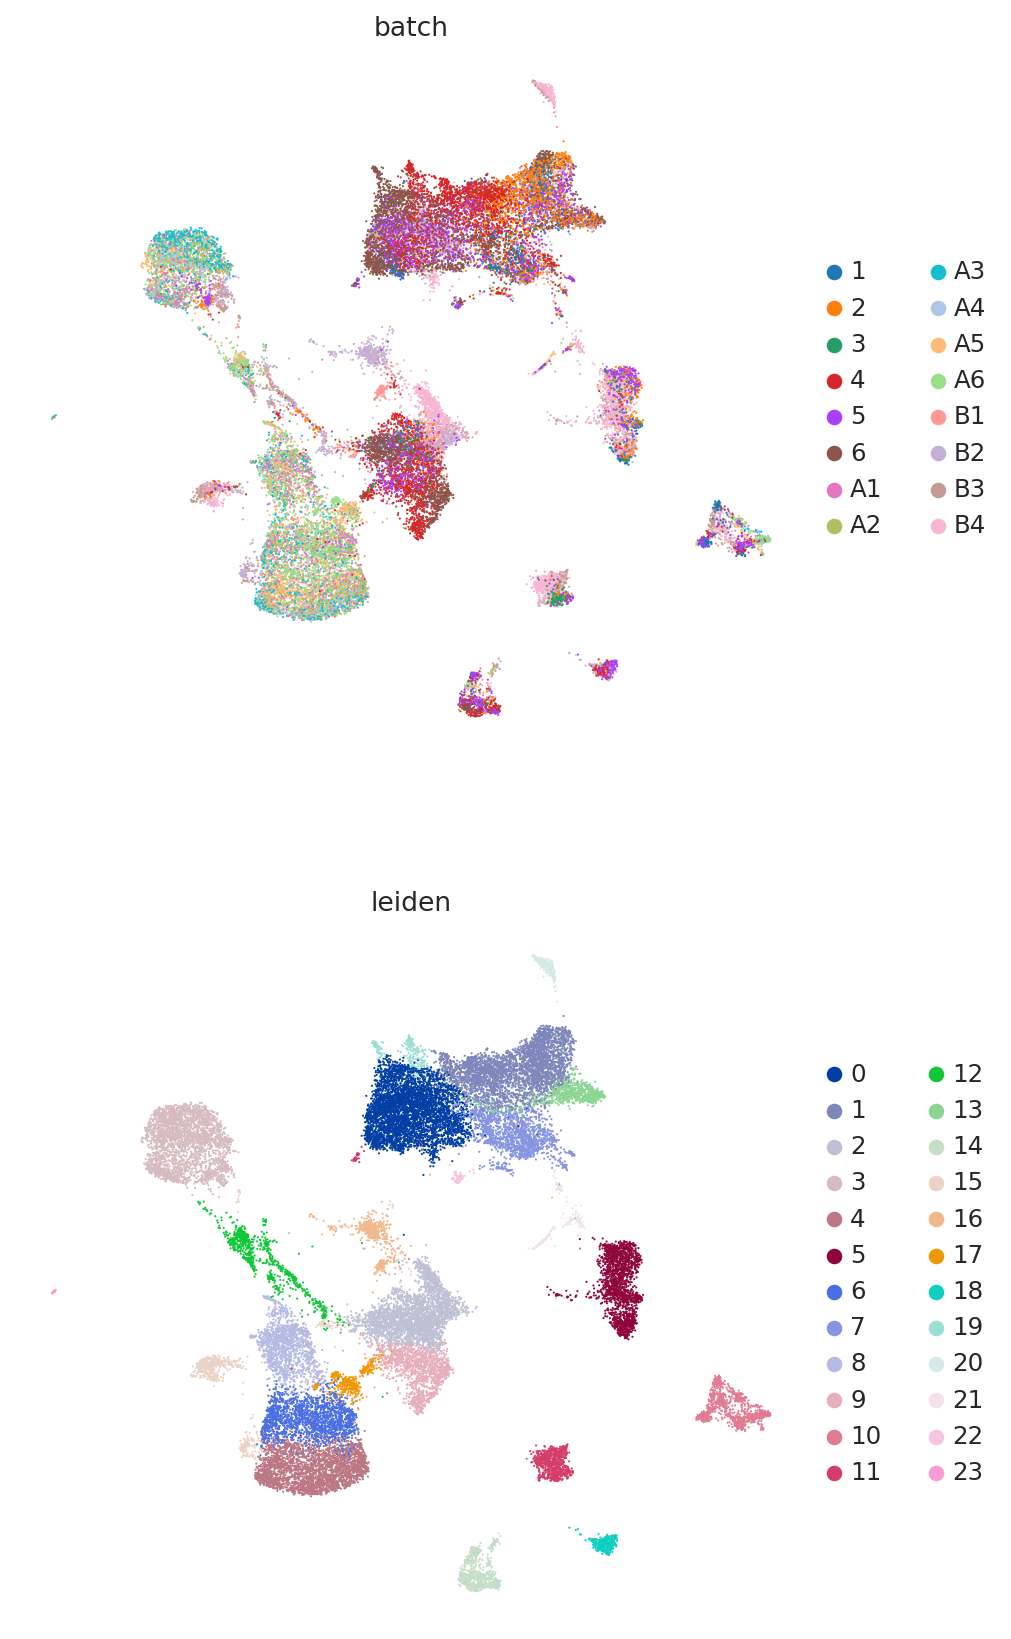

In [13]:
sc.tl.umap(adata, min_dist=0.3)
sc.pl.umap(
    adata,
    color=["batch", "leiden"],
    frameon=False,
    ncols=1,
)

Because this data has been used for benchmarking, we have access here to curated annotations. We can use those to assess whether the integration worked reasonably well.

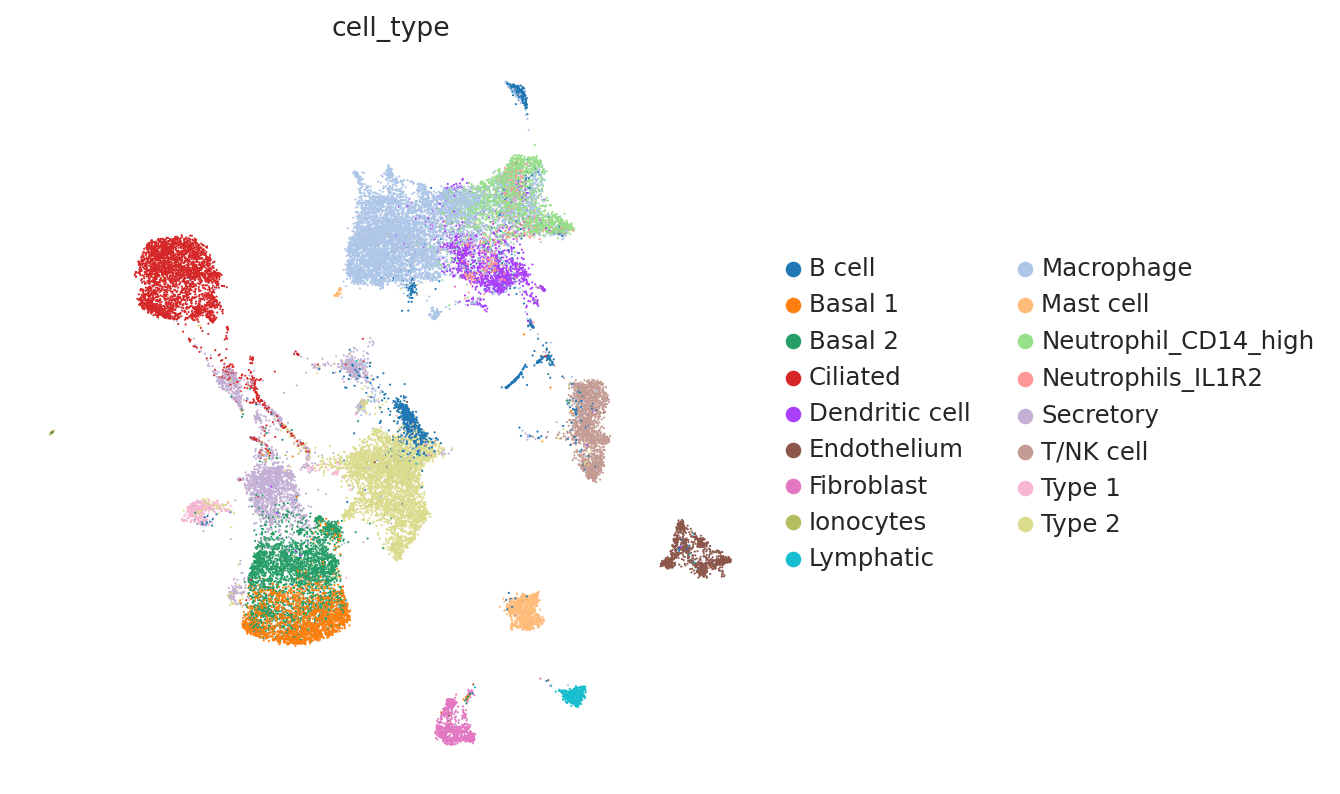

In [14]:
sc.pl.umap(
    adata,
    color=["cell_type"],
    frameon=False,
    ncols=1,
)

At a quick glance, it looks like the integration worked well. Indeed, the two datasets are relatively mixed in latent space and the cell types cluster together. We see that this dataset is quite complex, where only some batches contain certain cell types.

Below we quantify the performance.

## Integration with scANVI

Previously, we used scVI as we assumed we did not have any cell type annotations available to guide us. Consequently, after the previous analysis, one would have to annotate clusters using differential expression, or by other means.

Now, we assume that all of our data is annotated. This can lead to a more accurate integration result when using scANVI, i.e., our latent data manifold is better suited to downstream tasks like visualization, trajectory inference, or nearest-neighbor-based tasks. scANVI requires:

- the sample identifier for each cell (as in scVI)
- the cell type/state for each cell

scANVI can also be used for label transfer and we recommend checking out the other scANVI tutorials to see explore this functionality.

Since we've already trained an scVI model on our data, we will use it to initialize scANVI.  When initializing scANVI, we provide it the `labels_key`. As scANVI can also be used for datasets with partially-observed annotations, we need to give it the name of the category that corresponds to unlabeled cells. As we have no unlabeled cells, we can give it any random name that is not the name of an exisiting cell type.

```{important}
scANVI should be initialized from a scVI model pre-trained on the same exact data.
```

In [15]:
scanvi_model = scvi.model.SCANVI.from_scvi_model(
    model,
    adata=adata,
    labels_key="cell_type",
    unlabeled_category="Unknown",
)

/home/access/miniconda3/lib/python3.12/site-packages/scvi/data/fields/_base_field.py:63: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)


In [16]:
scanvi_model.train(max_epochs=20, n_samples_per_label=100, accelerator="gpu",devices=-1,strategy="ddp_notebook_find_unused_parameters_true",)

INFO     Training for 20 epochs.                                                                                   


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


RuntimeError: Lightning can't create new processes if CUDA is already initialized. Did you manually call `torch.cuda.*` functions, have moved the model to the device, or allocated memory on the GPU any other way? Please remove any such calls, or change the selected strategy. You will have to restart the Python kernel.

Now we can retrieve the latent space

In [17]:
SCANVI_LATENT_KEY = "X_scANVI"
adata.obsm[SCANVI_LATENT_KEY] = scanvi_model.get_latent_representation(adata)

RuntimeError: Trying to query inferred values from an untrained model. Please train the model first.

Again, we may visualize the latent space as well as the inferred labels

In [18]:
sc.pp.neighbors(adata, use_rep=SCANVI_LATENT_KEY)
sc.tl.umap(adata, min_dist=0.3)

ValueError: Did not find X_scANVI in `.obsm.keys()`. You need to compute it first.

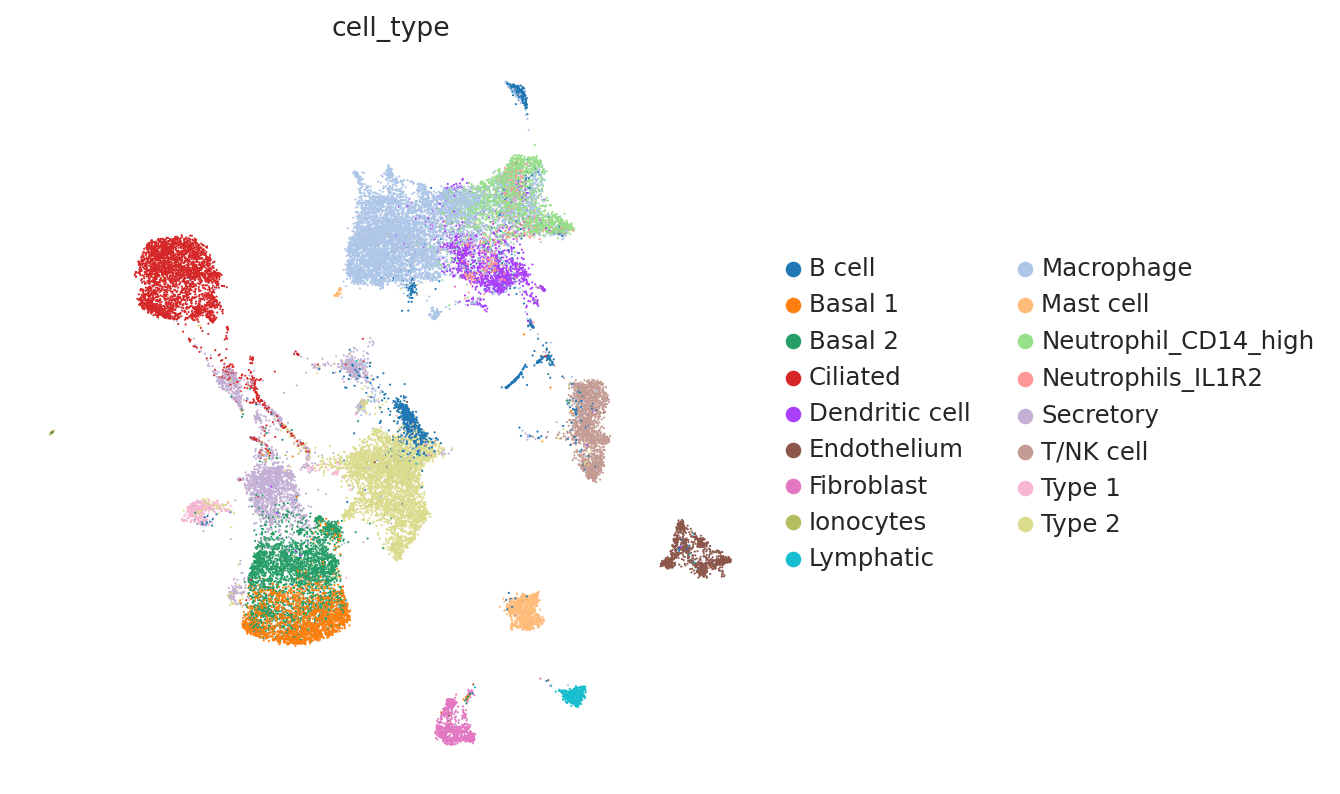

In [19]:
sc.pl.umap(
    adata,
    color=["cell_type"],
    frameon=False,
    ncols=1,
)

### Compute integration metrics

Here we use the [scib-metrics](https://scib-metrics.readthedocs.io/en/stable/) package, which contains scalable implementations of the metrics used in the scIB benchmarking suite. We can use these metrics to assess the quality of the integration.

We can see that the additional training with label information and scANVI improved the metrics that capture bio conservation (`cLISI, Silhouette labels`) without sacrificing too much batch correction power (`iLISI, Silhouette batch`)

In [20]:
bm = Benchmarker(
    adata,
    batch_key="batch",
    label_key="cell_type",
    embedding_obsm_keys=["X_pca", SCVI_LATENT_KEY, SCANVI_LATENT_KEY],
    n_jobs=-1,
)
bm.benchmark()

/home/access/miniconda3/lib/python3.12/site-packages/scanpy/preprocessing/_pca.py:374: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  warn(msg, FutureWarning)


KeyError: 'X_scANVI'

Computing neighbors:  33%|███▎      | 1/3 [00:06<00:12,  6.24s/it]

Computing neighbors:  67%|██████▋   | 2/3 [00:11<00:05,  5.65s/it]

Computing neighbors: 100%|██████████| 3/3 [00:17<00:00,  5.64s/it]

Computing neighbors: 100%|██████████| 3/3 [00:17<00:00,  5.70s/it]

Embeddings:   0%|          | 0/3 [00:00<?, ?it/s]

Metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Metrics:   0%|          | 0/10 [00:00<?, ?it/s, Bio conservation: isolated_labels]

2024-09-25 17:14:30.638301: W external/xla/xla/service/gpu/nvptx_compiler.cc:893] The NVIDIA driver's CUDA version is 12.4 which is older than the PTX compiler version 12.6.68. Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


Metrics:  10%|█         | 1/10 [00:26<03:57, 26.39s/it, Bio conservation: isolated_labels]

Metrics:  10%|█         | 1/10 [00:26<03:57, 26.39s/it, Bio conservation: nmi_ari_cluster_labels_kmeans]

Metrics:  20%|██        | 2/10 [00:27<01:33, 11.74s/it, Bio conservation: nmi_ari_cluster_labels_kmeans]

Metrics:  20%|██        | 2/10 [00:27<01:33, 11.74s/it, Bio conservation: silhouette_label]             

Metrics:  30%|███       | 3/10 [00:53<02:05, 18.00s/it, Bio conservation: silhouette_label]

Metrics:  30%|███       | 3/10 [00:53<02:05, 18.00s/it, Bio conservation: clisi_knn]       

Metrics:  40%|████      | 4/10 [01:11<01:48, 18.12s/it, Bio conservation: clisi_knn]

Metrics:  40%|████      | 4/10 [01:11<01:48, 18.12s/it, Batch correction: silhouette_batch]

Metrics:  50%|█████     | 5/10 [01:22<01:18, 15.63s/it, Batch correction: silhouette_batch]

Metrics:  50%|█████     | 5/10 [01:22<01:18, 15.63s/it, Batch correction: ilisi_knn]       

Metrics:  60%|██████    | 6/10 [01:40<01:05, 16.31s/it, Batch correction: ilisi_knn]

Metrics:  60%|██████    | 6/10 [01:40<01:05, 16.31s/it, Batch correction: kbet_per_label]

/usr/local/lib/python3.12/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


/usr/local/lib/python3.12/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


/usr/local/lib/python3.12/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


/usr/local/lib/python3.12/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


/usr/local/lib/python3.12/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


/usr/local/lib/python3.12/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


/usr/local/lib/python3.12/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


/usr/local/lib/python3.12/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


/usr/local/lib/python3.12/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


/usr/local/lib/python3.12/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


/usr/local/lib/python3.12/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


/usr/local/lib/python3.12/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


/usr/local/lib/python3.12/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


/usr/local/lib/python3.12/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


/usr/local/lib/python3.12/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


Metrics:  70%|███████   | 7/10 [01:53<00:45, 15.15s/it, Batch correction: kbet_per_label]

Metrics:  70%|███████   | 7/10 [01:53<00:45, 15.15s/it, Batch correction: graph_connectivity]

/usr/local/lib/python3.12/site-packages/scib_metrics/_graph_connectivity.py:30: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(comps)



Metrics:  80%|████████  | 8/10 [01:53<00:30, 15.15s/it, Batch correction: pcr_comparison]    

Metrics:  90%|█████████ | 9/10 [01:53<00:07,  7.92s/it, Batch correction: pcr_comparison]

Embeddings:  33%|███▎      | 1/3 [01:53<03:47, 113.59s/it]

Metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Metrics:   0%|          | 0/10 [00:00<?, ?it/s, Bio conservation: isolated_labels]

Metrics:  10%|█         | 1/10 [00:25<03:51, 25.67s/it, Bio conservation: isolated_labels]

Metrics:  10%|█         | 1/10 [00:25<03:51, 25.67s/it, Bio conservation: nmi_ari_cluster_labels_kmeans]

Metrics:  20%|██        | 2/10 [00:27<01:31, 11.40s/it, Bio conservation: nmi_ari_cluster_labels_kmeans]

Metrics:  20%|██        | 2/10 [00:27<01:31, 11.40s/it, Bio conservation: silhouette_label]             

Metrics:  30%|███       | 3/10 [00:52<02:05, 17.95s/it, Bio conservation: silhouette_label]

Metrics:  30%|███       | 3/10 [00:52<02:05, 17.95s/it, Bio conservation: clisi_knn]       

Metrics:  40%|████      | 4/10 [01:10<01:46, 17.81s/it, Bio conservation: clisi_knn]

Metrics:  40%|████      | 4/10 [01:10<01:46, 17.81s/it, Batch correction: silhouette_batch]

Metrics:  50%|█████     | 5/10 [01:14<01:04, 12.99s/it, Batch correction: silhouette_batch]

Metrics:  50%|█████     | 5/10 [01:14<01:04, 12.99s/it, Batch correction: ilisi_knn]       

Metrics:  60%|██████    | 6/10 [01:32<00:58, 14.65s/it, Batch correction: ilisi_knn]

Metrics:  60%|██████    | 6/10 [01:32<00:58, 14.65s/it, Batch correction: kbet_per_label]

/usr/local/lib/python3.12/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


/usr/local/lib/python3.12/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


/usr/local/lib/python3.12/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


/usr/local/lib/python3.12/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


/usr/local/lib/python3.12/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


/usr/local/lib/python3.12/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


/usr/local/lib/python3.12/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


/usr/local/lib/python3.12/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


/usr/local/lib/python3.12/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


/usr/local/lib/python3.12/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


/usr/local/lib/python3.12/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


/usr/local/lib/python3.12/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


/usr/local/lib/python3.12/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


/usr/local/lib/python3.12/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


/usr/local/lib/python3.12/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


Metrics:  70%|███████   | 7/10 [01:45<00:41, 13.98s/it, Batch correction: kbet_per_label]

Metrics:  70%|███████   | 7/10 [01:45<00:41, 13.98s/it, Batch correction: graph_connectivity]

/usr/local/lib/python3.12/site-packages/scib_metrics/_graph_connectivity.py:30: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(comps)



Metrics:  80%|████████  | 8/10 [01:45<00:27, 13.98s/it, Batch correction: pcr_comparison]    

Metrics:  90%|█████████ | 9/10 [01:45<00:07,  7.29s/it, Batch correction: pcr_comparison]

Embeddings:  67%|██████▋   | 2/3 [03:39<01:48, 108.89s/it]

Metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Metrics:   0%|          | 0/10 [00:00<?, ?it/s, Bio conservation: isolated_labels]

Metrics:  10%|█         | 1/10 [00:25<03:51, 25.76s/it, Bio conservation: isolated_labels]

Metrics:  10%|█         | 1/10 [00:25<03:51, 25.76s/it, Bio conservation: nmi_ari_cluster_labels_kmeans]

Metrics:  20%|██        | 2/10 [00:27<01:31, 11.40s/it, Bio conservation: nmi_ari_cluster_labels_kmeans]

Metrics:  20%|██        | 2/10 [00:27<01:31, 11.40s/it, Bio conservation: silhouette_label]             

Metrics:  30%|███       | 3/10 [00:52<02:05, 17.87s/it, Bio conservation: silhouette_label]

Metrics:  30%|███       | 3/10 [00:52<02:05, 17.87s/it, Bio conservation: clisi_knn]       

Metrics:  40%|████      | 4/10 [01:10<01:47, 17.87s/it, Bio conservation: clisi_knn]

Metrics:  40%|████      | 4/10 [01:10<01:47, 17.87s/it, Batch correction: silhouette_batch]

Metrics:  50%|█████     | 5/10 [01:13<01:02, 12.58s/it, Batch correction: silhouette_batch]

Metrics:  50%|█████     | 5/10 [01:13<01:02, 12.58s/it, Batch correction: ilisi_knn]       

Metrics:  60%|██████    | 6/10 [01:31<00:57, 14.30s/it, Batch correction: ilisi_knn]

Metrics:  60%|██████    | 6/10 [01:31<00:57, 14.30s/it, Batch correction: kbet_per_label]

/usr/local/lib/python3.12/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


/usr/local/lib/python3.12/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


/usr/local/lib/python3.12/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


/usr/local/lib/python3.12/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/usr/local/lib/python3.12/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


/usr/local/lib/python3.12/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


/usr/local/lib/python3.12/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


/usr/local/lib/python3.12/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


/usr/local/lib/python3.12/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


/usr/local/lib/python3.12/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


/usr/local/lib/python3.12/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


/usr/local/lib/python3.12/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


Metrics:  70%|███████   | 7/10 [01:42<00:39, 13.20s/it, Batch correction: kbet_per_label]

Metrics:  70%|███████   | 7/10 [01:42<00:39, 13.20s/it, Batch correction: graph_connectivity]

/usr/local/lib/python3.12/site-packages/scib_metrics/_graph_connectivity.py:30: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(comps)



Metrics:  80%|████████  | 8/10 [01:42<00:26, 13.20s/it, Batch correction: pcr_comparison]    

Embeddings: 100%|██████████| 3/3 [05:21<00:00, 105.92s/it]

Embeddings: 100%|██████████| 3/3 [05:21<00:00, 107.19s/it]

In [21]:
bm.plot_results_table(min_max_scale=False)

KeyError: 'Batch correction'

In [ ]:
df = bm.get_results(min_max_scale=False)
print(df)